# Component Grids for Increasing Gaussian Measures

In [1]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [2]:
def train_model(mean):
    
    custom_measure = MOGMeasure(means=np.array([mean]), variances=np.array([1.0]), weights=np.array([1.0]))
    gmm_measures_list = [custom_measure]


    # --- Create AGP model ---
    data = (X_train, y_train)
    model1 = create_model_oak(
             data=data,
             max_interaction_depth=1,
             constrain_orthogonal=True,
             share_var_across_orders=True,
             use_sparsity_prior=False,
             gmm_measures=gmm_measures_list,
    )
    model1.kernel.kernels[0].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model1.kernel.kernels[0].base_kernel.variance, False)


    # --- Train model ---
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model1.training_loss, model1.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

    K_oak = model1.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model1.likelihood.variance.numpy()
    alpha_oak = tf.linalg.solve(K_oak, tf.convert_to_tensor(y_train, dtype=tf.float64))
    oak_datafit = 0.5 * y_train.T@alpha_oak
    L = tf.linalg.cholesky(K_oak)
    oak_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L))).numpy()


    print(f"Complexity is {oak_complexity}, datafit is {oak_datafit}")

    return model1

In [3]:
def plot_components(model):

    alpha = get_model_sufficient_statistics(model, get_L=False)
    selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=1)
    K = model.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model.likelihood.variance.numpy()

    mu0 = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
    mu1 = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
    mu = eval_component(model.kernel, alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))

    f0 = mu0*y_std + y_mean
    f1 = mu1*y_std
    f = mu*y_std + y_mean

    var_f1_tensor = get_component_variance(kernel_list[1], K, X_test_tf, X_train)
    var_f1 = var_f1_tensor.numpy()
    std_f1_oak = np.sqrt(var_f1).reshape(-1,1) * y_std

    var_f0_tensor = get_component_variance(kernel_list[0], K, X_test_tf, X_train)
    var_f0 = var_f0_tensor.numpy()
    std_f0_oak = np.sqrt(var_f0).reshape(-1,1) * y_std

    var_f_tensor = get_component_variance(model.kernel, K, X_test_tf, X_train)
    var_f = var_f_tensor.numpy()
    std_f_oak = np.sqrt(var_f).reshape(-1,1) * y_std

    return f0, f1, f, std_f0_oak, std_f1_oak, std_f_oak

In [5]:
def print_comp(mu1, low1, high1, mean, title=None):
    
    idx = int(mean)
    ax[idx].plot(x1_plot.reshape(100), mu1, label='$f_1(x)$', color='cornflowerblue')
    ax[idx].fill_between(x1_plot.reshape(100), low1, high1, color='cornflowerblue', alpha=0.3)
    ax[idx].plot(X_train, y_orig, 'x', color='red', label='Training Data')
    if title != None:
        ax[idx].set_title(title, fontsize=20)
    else:
        ax[idx].set_title(f"Component Decomposition Under N({mean},1) Orthogonality", fontsize=20)
    ax[idx].grid('on')
    ax[idx].set_xlabel('$x$')
    ax[idx].set_ylabel('$y$')
    ax[idx].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=16)

In [6]:
# --- Generate synthetic 2D data ---
def true_function(X):
    return 0.1*X**2


n = 100
noise = 0.01
X = np.random.normal(loc=0.0, scale=1.0, size=n)
y = true_function(X) + np.random.normal(0, noise, size=n)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

kf = KFold(n_splits=10, shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break


y_mean, y_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

Complexity is -227.95208682907804, datafit is [[45.00000]]
Model with mean 0.0 has NMLL -100.24761718702908, mean component variance 3.2912307851216087
Test Metrics: NLL: -1.2760, Model MSE: 0.0092

Complexity is -223.157648870245, datafit is [[44.99989]]
Model with mean 1.0 has NMLL -95.45329191001281, mean component variance 3.267799726251978
Test Metrics: NLL: -1.3166, Model MSE: 0.0088

Complexity is -221.8162225227937, datafit is [[45.00005]]
Model with mean 2.0 has NMLL -94.11170606384128, mean component variance 3.356171725577819
Test Metrics: NLL: -1.3170, Model MSE: 0.0088

Complexity is -221.0623037881388, datafit is [[44.99996]]
Model with mean 3.0 has NMLL -93.3578770169723, mean component variance 3.48057477100817
Test Metrics: NLL: -1.3174, Model MSE: 0.0088

Complexity is -220.56920376778578, datafit is [[45.00003]]
Model with mean 4.0 has NMLL -92.86470980564772, mean component variance 3.6039873709813532
Test Metrics: NLL: -1.3180, Model MSE: 0.0088

Complexity is -220

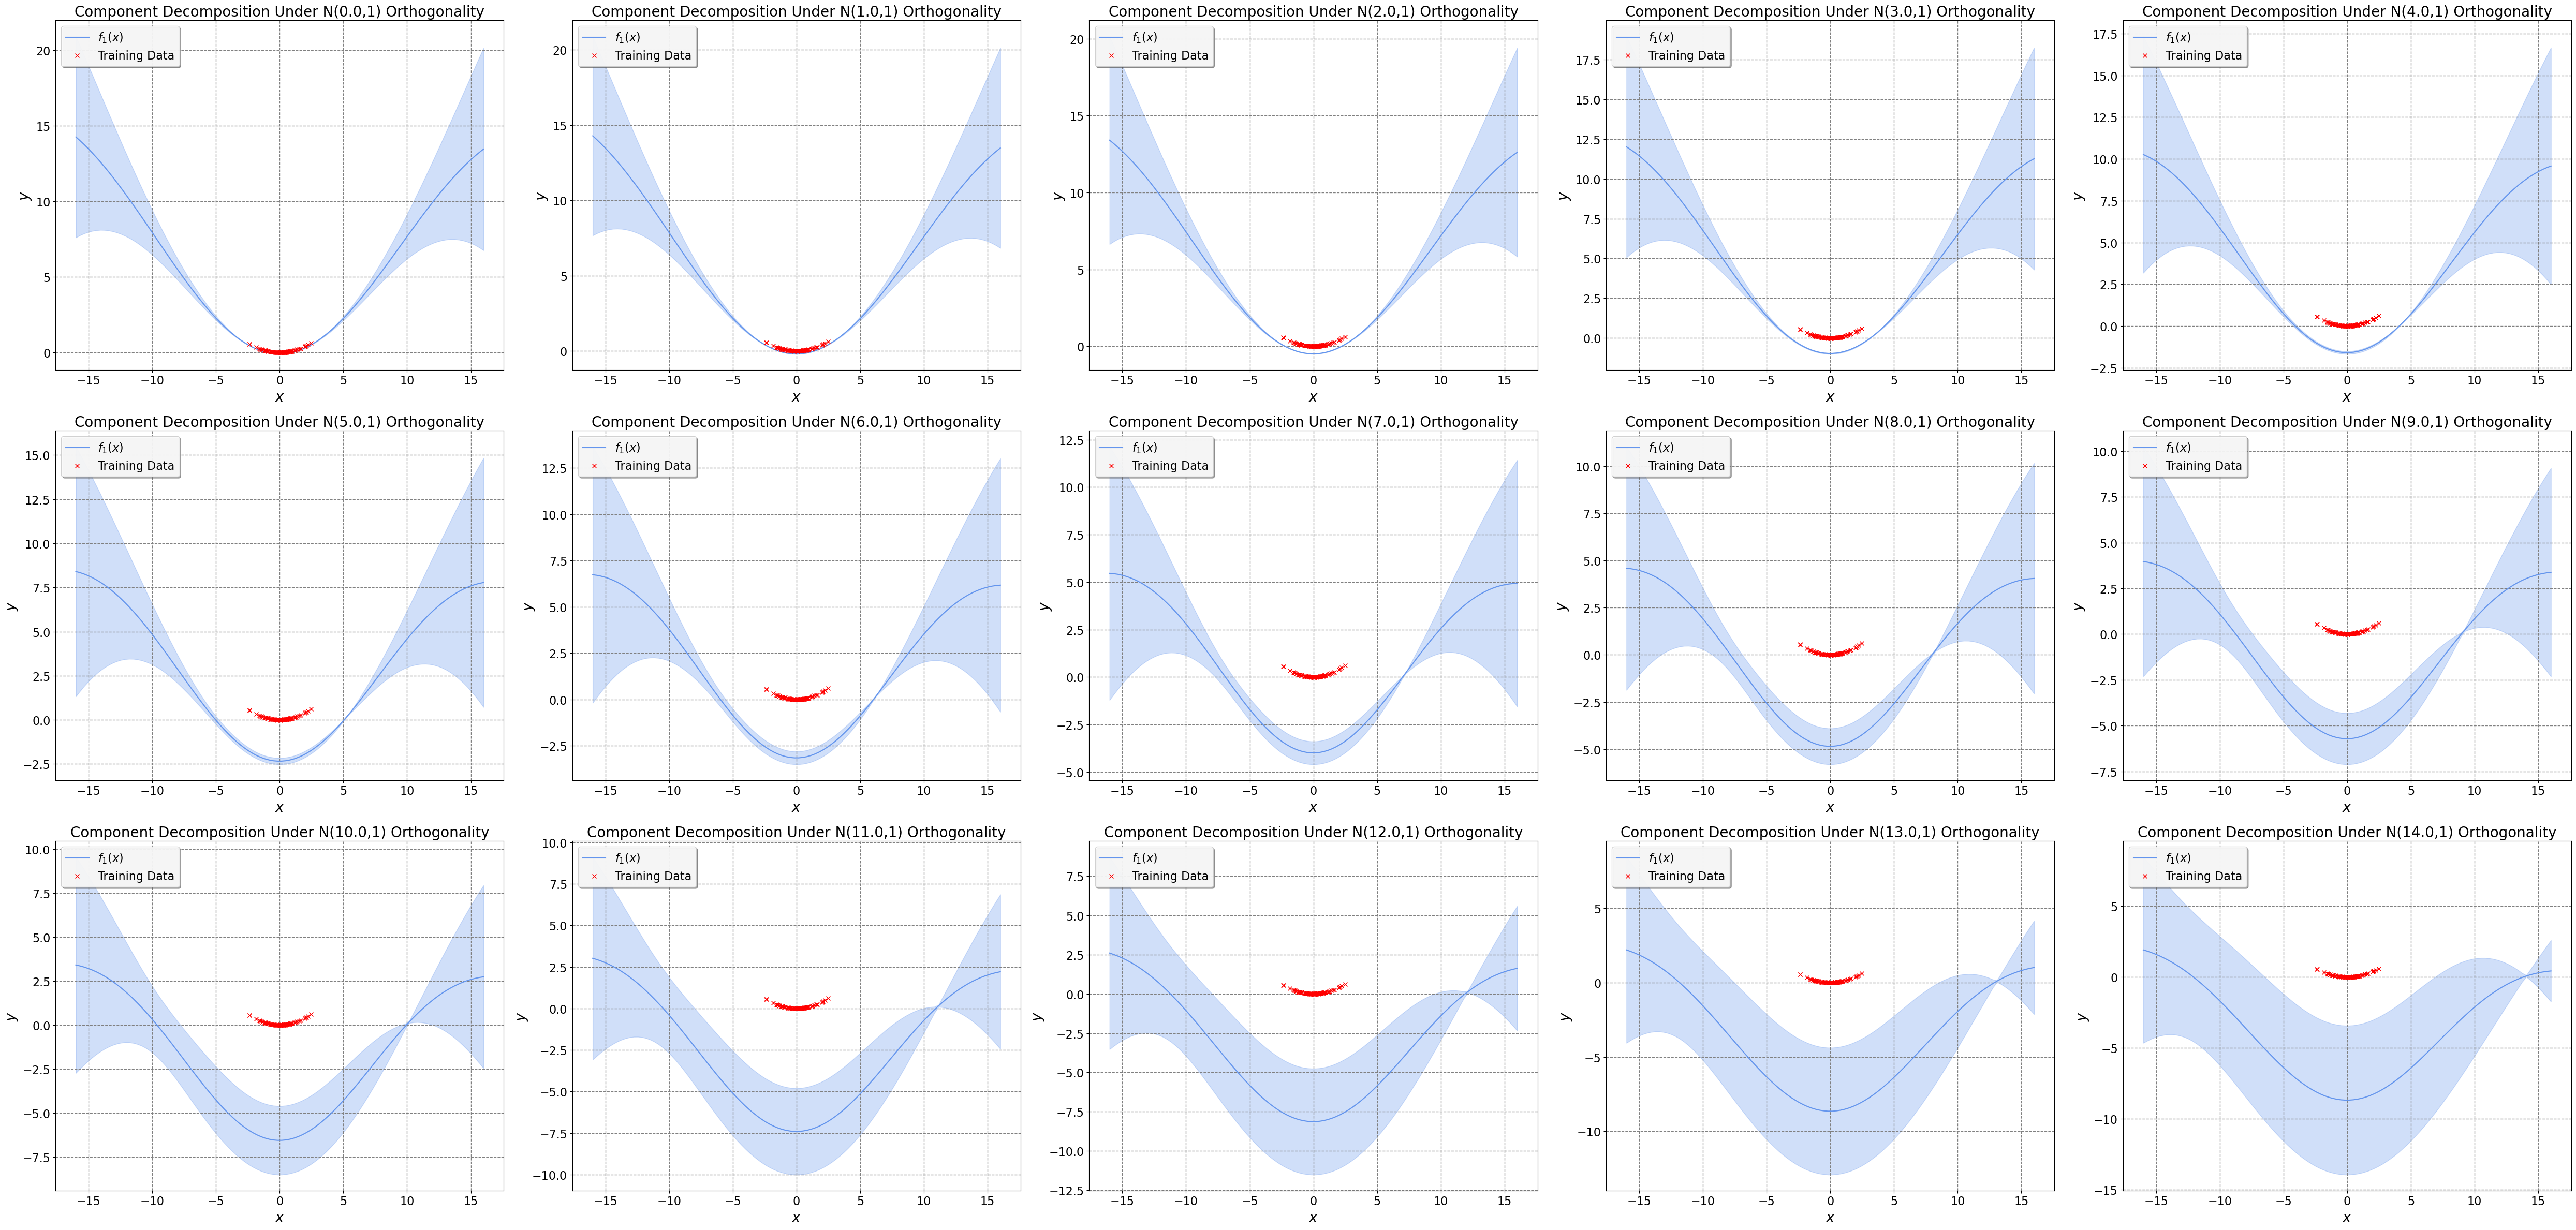

In [7]:
x1_plot = np.linspace(-16, 16, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])

mean_arr = np.linspace(0,14,15)
y_orig = y_train * y_std + y_mean
fig, axes = plt.subplots(3, 5, figsize=(50, 24))
ax = axes.flatten()

for mean in mean_arr:
    model = train_model(mean)
    mu0, mu1, mu, std_f0_oak, std_f1_oak, std_f_oak = plot_components(model)

    low1 = (mu1 - 2*std_f1_oak).reshape(100)
    high1 = (mu1 + 2*std_f1_oak).reshape(100)

    print(f"Model with mean {mean} has NMLL {model.training_loss().numpy()}, mean component variance {np.mean(high1-low1)}")
    nmll, nll, mse = test_metrics(model, X_test, y_test, y_mean, y_std)
    print(f"Test Metrics: NLL: {nll:.4f}, Model MSE: {mse:.4f}\n")

    print_comp(mu1, low1, high1, mean)


plt.tight_layout()
plt.show()

Complexity is -227.95208682907804, datafit is [[45.00000]]
Model with mean 0.0 has NMLL -100.24761718702908, mean component variance 17.969599462279565
Test Metrics: NLL: -1.2760, Model MSE: 0.0092

Complexity is -223.157648870245, datafit is [[44.99989]]
Model with mean 1.0 has NMLL -95.45329191001281, mean component variance 17.941972596595118
Test Metrics: NLL: -1.3166, Model MSE: 0.0088

Complexity is -221.8162225227937, datafit is [[45.00005]]
Model with mean 2.0 has NMLL -94.11170606384128, mean component variance 17.744317927499097
Test Metrics: NLL: -1.3170, Model MSE: 0.0088

Complexity is -221.0623037881388, datafit is [[44.99996]]
Model with mean 3.0 has NMLL -93.3578770169723, mean component variance 17.274335563134933
Test Metrics: NLL: -1.3174, Model MSE: 0.0088

Complexity is -220.56920376778578, datafit is [[45.00003]]
Model with mean 4.0 has NMLL -92.86470980564772, mean component variance 16.417391519784495
Test Metrics: NLL: -1.3180, Model MSE: 0.0088

Complexity is 

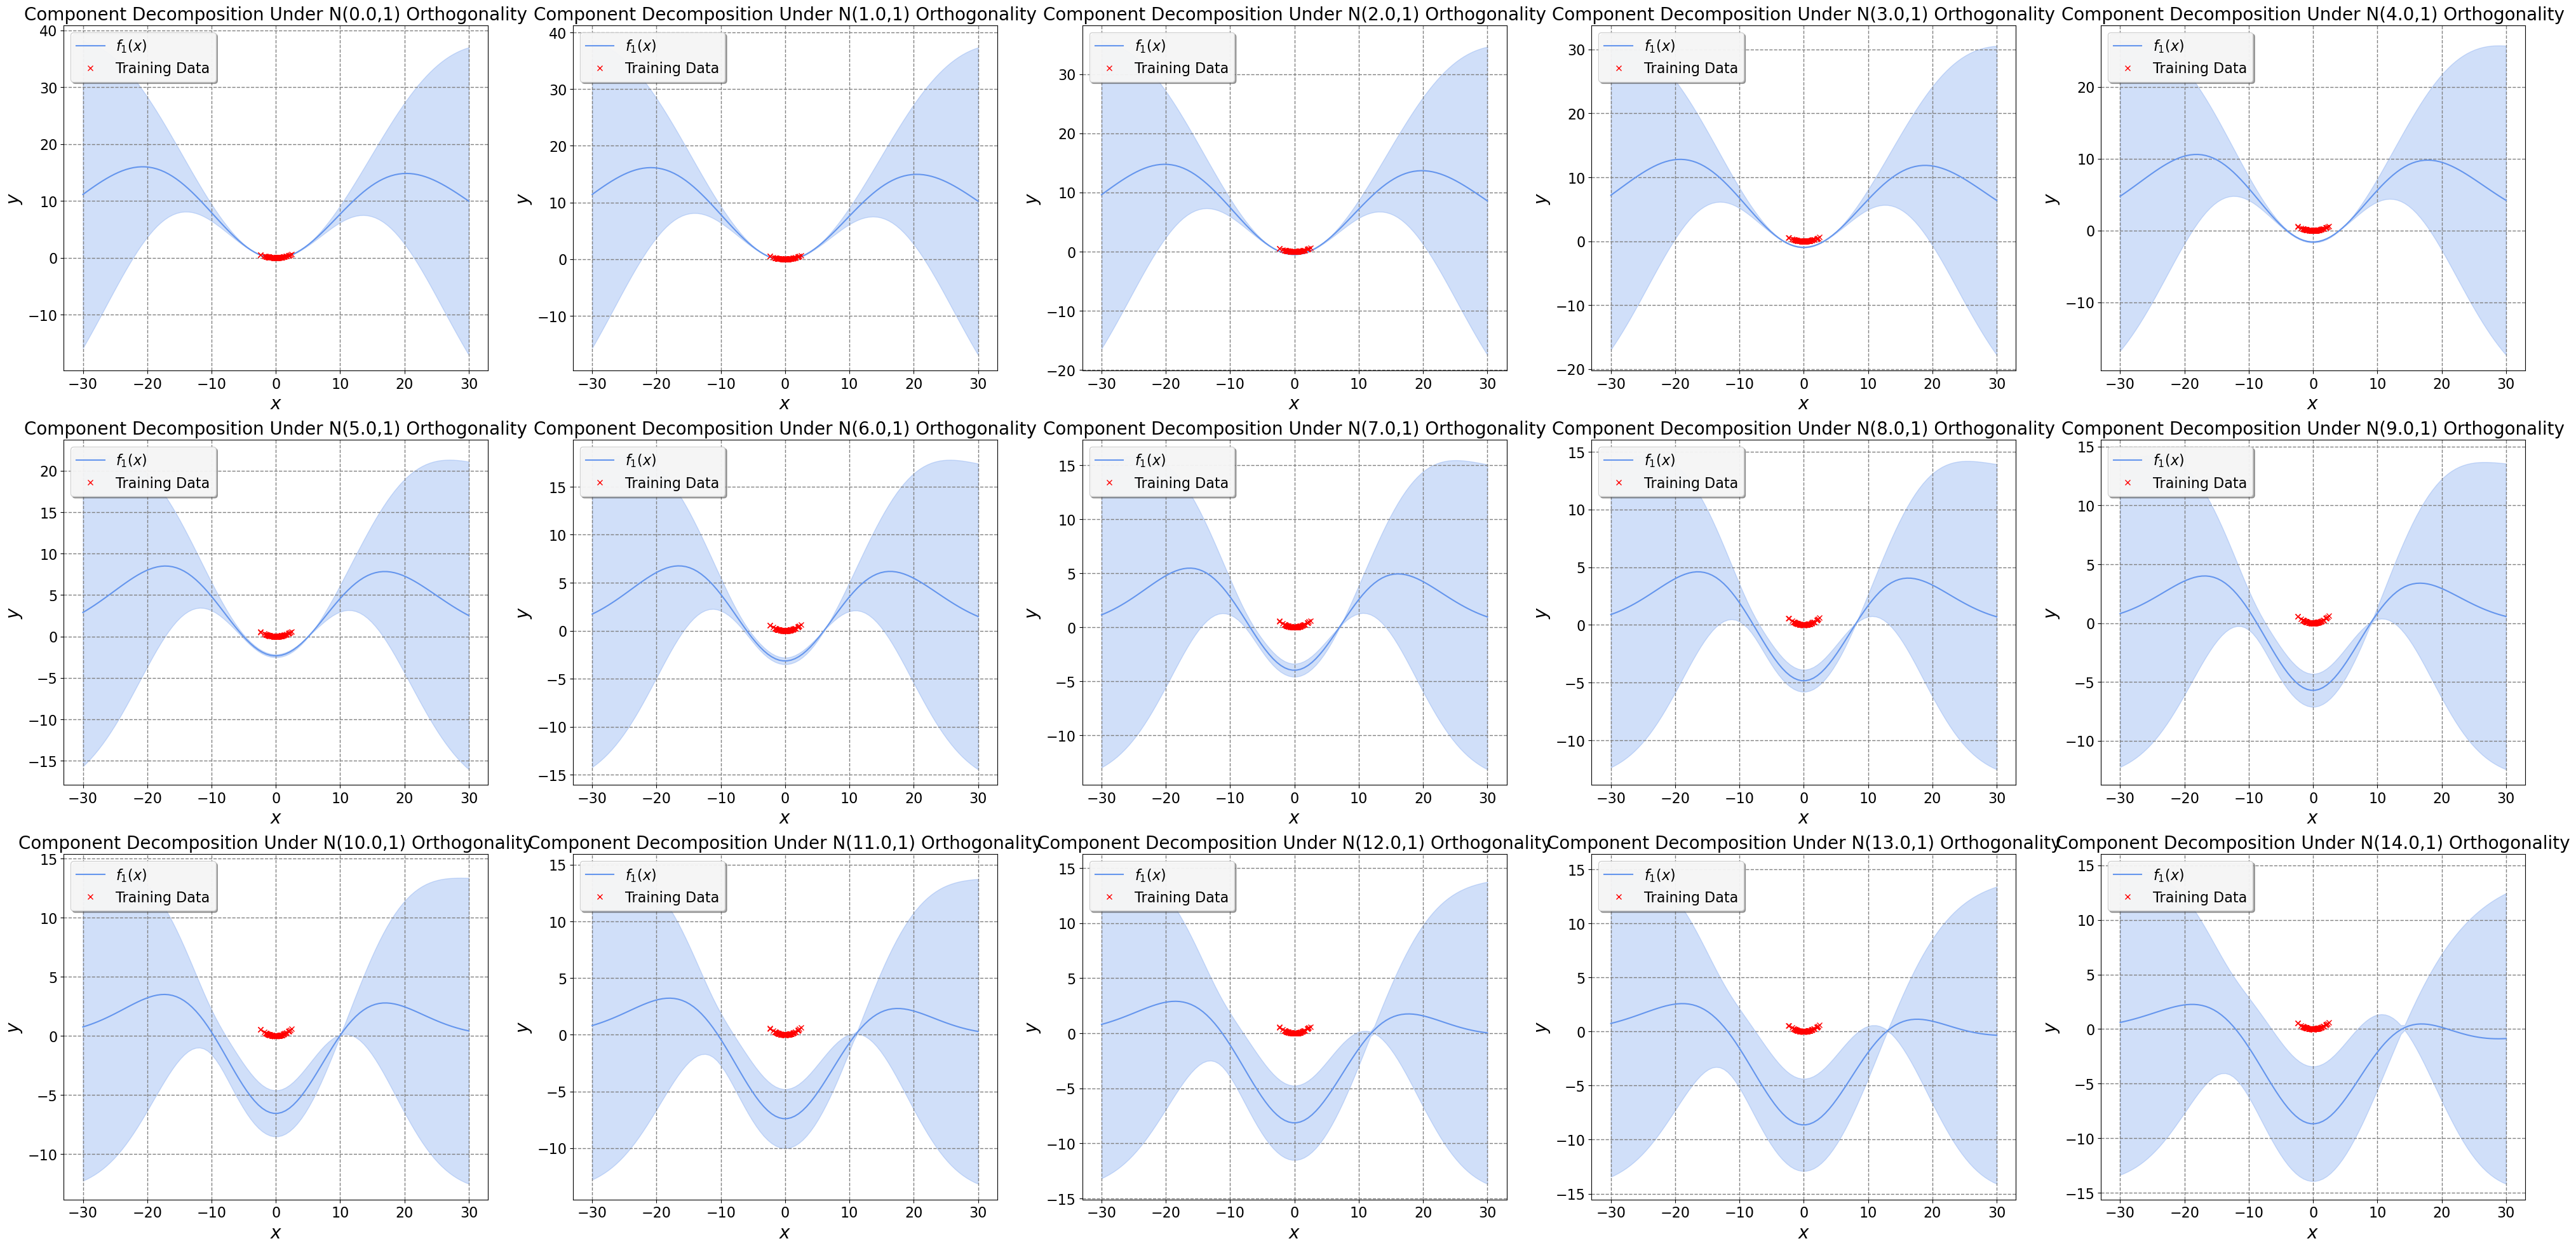

In [8]:
# --- Generate synthetic 2D data ---
def true_function(X):
    return 0.1*X**2


seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

n = 100
noise = 0.01
X = np.random.normal(loc=0.0, scale=1.0, size=n)
y = true_function(X) + np.random.normal(0, noise, size=n)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

kf = KFold(n_splits=10, shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break


y_mean, y_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std


x1_plot = np.linspace(-30, 30, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])

mean_arr = np.linspace(0,14,15)
y_orig = y_train * y_std + y_mean
fig, axes = plt.subplots(3, 5, figsize=(50, 24))
ax = axes.flatten()

for mean in mean_arr:
    model = train_model(mean)
    mu0, mu1, mu, std_f0_oak, std_f1_oak, std_f_oak = plot_components(model)

    low1 = (mu1 - 2*std_f1_oak).reshape(100)
    high1 = (mu1 + 2*std_f1_oak).reshape(100)

    print(f"Model with mean {mean} has NMLL {model.training_loss().numpy()}, mean component variance {np.mean(high1-low1)}")
    nmll, nll, mse = test_metrics(model, X_test, y_test, y_mean, y_std)
    print(f"Test Metrics: NLL: {nll:.4f}, Model MSE: {mse:.4f}\n")

    print_comp(mu1, low1, high1, mean)


plt.show()

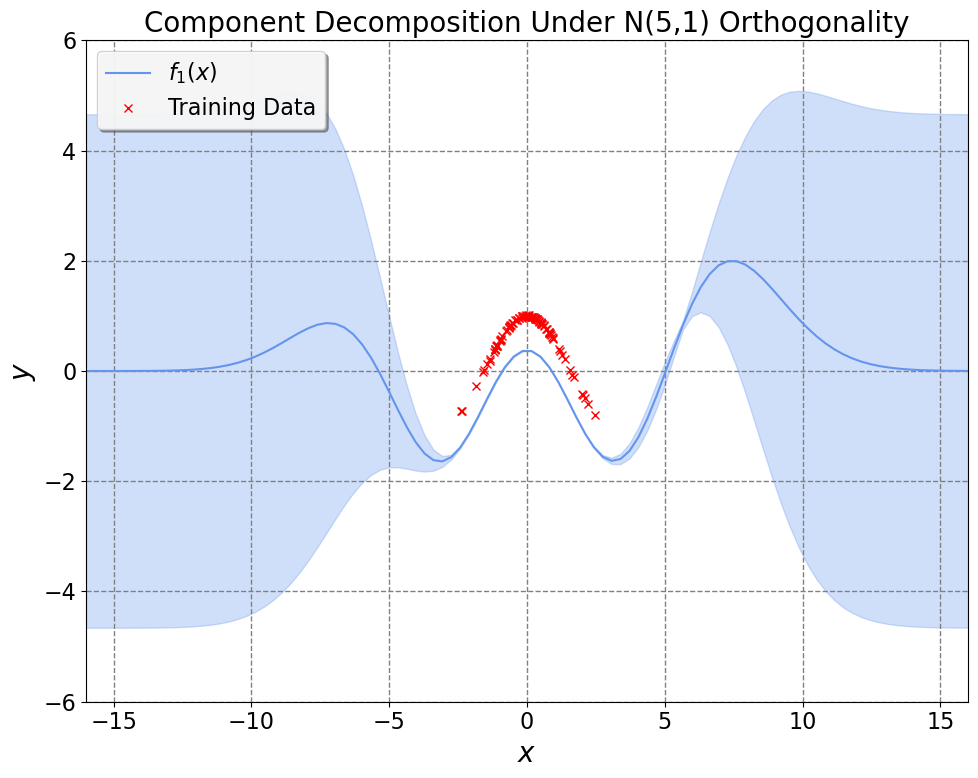

In [9]:
# --- Generate synthetic 2D data ---
def true_function(X):
    return np.cos(X)


seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

n = 100
noise = 0.01
#X = np.random.uniform(-3, 3, size=n)
X = np.random.normal(loc=0, scale=1, size=n)
y = true_function(X) + np.random.normal(0, noise, size=n)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std


X_train = X
y_train = y

x1_plot = np.linspace(-16, 16, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])

y_orig = y * y_std + y_mean


custom_measure = MOGMeasure(means=np.array([5]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure]


# --- Create AGP model ---
data = (X_train, y_train)
model = create_model_oak(
             data=(X_train, y_train),
             max_interaction_depth=1,
             constrain_orthogonal=True,
             share_var_across_orders=True,
             use_sparsity_prior=False,
             gmm_measures=gmm_measures_list,
)
model.kernel.kernels[0].base_kernel.variance.assign(1.0)
gpflow.set_trainable(model.kernel.kernels[0].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=1)
K = model.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model.likelihood.variance.numpy()

mu0 = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu1 = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu = eval_component(model.kernel, alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))

f0 = mu0*y_std + y_mean
f1 = mu1*y_std
f = mu*y_std + y_mean

var_f1_tensor = get_component_variance(kernel_list[1], K, X_test_tf, X_train)
var_f1 = var_f1_tensor.numpy()
std_f1_oak = np.sqrt(var_f1).reshape(-1,1) * y_std

var_f0_tensor = get_component_variance(kernel_list[0], K, X_test_tf, X_train)
var_f0 = var_f0_tensor.numpy()
std_f0_oak = np.sqrt(var_f0).reshape(-1,1) * y_std

var_f_tensor = get_component_variance(model.kernel, K, X_test_tf, X_train)
var_f = var_f_tensor.numpy()
std_f_oak = np.sqrt(var_f).reshape(-1,1) * y_std

low1 = (f1 - 2*std_f1_oak).reshape(100)
high1 = (f1 + 2*std_f1_oak).reshape(100)

plt.figure(figsize=(10,8))
plt.plot(x1_plot.reshape(100), f1, label='$f_1(x)$', color='cornflowerblue')
plt.fill_between(x1_plot.reshape(100), low1, high1, color='cornflowerblue', alpha=0.3)
plt.plot(X_train, y_orig, 'x', color='red', label='Training Data')
plt.title(f"Component Decomposition Under N(5,1) Orthogonality", fontsize=20)
plt.grid('on')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([-16,16])
plt.ylim([-6,6])
plt.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=16)

plt.tight_layout()
plt.show()